## Group Information

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.preprocessing import MultiLabelBinarizer,Normalizer,StandardScaler
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold
import statsmodels.formula.api as smf
from mlxtend.plotting import plot_learning_curves

from sklearn.linear_model import LinearRegression
import sklearn.cluster as cluster
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### Get data

In [2]:
# Get local path of data
path = os.path.abspath(os.getcwd())
#path = os.path.abspath(os.path.join(path, os.pardir)) + '\\airbnb-listings.json'
path = os.path.abspath(os.path.join(path, os.pardir)) + '\\Complete_dataset.csv'
path

'c:\\Users\\HP\\Desktop\\Data Analyst\\Projects\\Complete_dataset.csv'

In [3]:
#df = pd.read_json(path)
df = pd.read_csv(path)
df = df.drop("Unnamed: 0",axis=1)

C:\Users\HP\AppData\Local\Temp\ipykernel_14260\4089235158.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


x =df['fields']
rows = len(x)
facets = ['id',
 'latitude',
 'longitude',
 'name',
 'host_id',
 'host_name',
 'host_response_time',
 'host_response_rate',
 'city',
 'country',
 'property_type',
 'room_type',
 'bed_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'extra_people',
 'price',
 'cancellation_policy',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'review_scores_value',
 'review_scores_cleanliness',
 'review_scores_accuracy',
 'calculated_host_listings_count',
 'amenities',
 'host_url']

x_records = []
for row in range(0,rows):
      data = x[row]
      x_records.append(data)

for ele in x_records:
    for f in facets:
        if f not in ele.keys():
            ele[f] = None

df2 = pd.DataFrame(x_records,columns=facets)
df2

In [4]:
df2 = df.copy()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494954 entries, 0 to 494953
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              494954 non-null  object 
 1   latitude                        494953 non-null  float64
 2   longitude                       494953 non-null  float64
 3   name                            494536 non-null  object 
 4   host_id                         494954 non-null  int64  
 5   host_name                       494450 non-null  object 
 6   host_response_time              379885 non-null  object 
 7   host_response_rate              379884 non-null  float64
 8   city                            494500 non-null  object 
 9   country                         494951 non-null  object 
 10  property_type                   494943 non-null  object 
 11  room_type                       494953 non-null  object 
 12  bed_type        

### Nan Values ?

In [5]:
nan_list = df2.isna().sum().to_numpy()
nan_idx = []
for i in range(len(nan_list)):
  if nan_list[i] > 0:
    tmp = []
    tmp.append(df2.keys()[i])
    tmp.append(df2[df2.keys()[i]].dtypes)
    tmp.append(nan_list[i])
    tmp.append(round(nan_list[i]/df2.shape[0] *100,2))
    nan_idx.append(tmp)
df3 = pd.DataFrame(nan_idx, columns = ["col_name","type","nan_amount","%"])
df3

,col_name,type,nan_amount,%
0,latitude,float64,1,0.00
1,longitude,float64,1,0.00
2,name,object,418,0.08
3,host_name,object,504,0.10
4,host_response_time,object,115069,23.25
5,host_response_rate,float64,115070,23.25
6,city,object,454,0.09
7,country,object,3,0.00
8,property_type,object,11,0.00
9,room_type,object,1,0.00


## Data Preprosessing

Dựa vào df3, ta có thể thấy các cột như accommodates, bathrooms, bedrooms,... có số lượng nan khá ít nên ta có thể cân nhắc bỏ các dòng có chứa nan ở các cột này.

In [6]:
df2 = df2.dropna(subset=["accommodates", "bathrooms", "bedrooms", "beds", "extra_people","property_type"])

Ngoài ra, khi xóa các dòng này "vô tình" khiến một lượng lớn nan ở các cột khác cũng biến mất.

In [7]:
nan_list = df2.isna().sum().to_numpy()
nan_idx = []
for i in range(len(nan_list)):
  if nan_list[i] > 0:
    tmp = []
    tmp.append(df2.keys()[i])
    tmp.append(df2[df2.keys()[i]].dtypes)
    tmp.append(nan_list[i])
    tmp.append(round(nan_list[i]/df2.shape[0] *100,2))
    nan_idx.append(tmp)
df3 = pd.DataFrame(nan_idx, columns = ["col_name","type","nan_amount","%"])
df3

,col_name,type,nan_amount,%
0,name,object,413,0.08
1,host_name,object,499,0.10
2,host_response_time,object,114351,23.22
3,host_response_rate,float64,114351,23.22
4,city,object,450,0.09
5,country,object,2,0.00
6,price,float64,7915,1.61
7,reviews_per_month,float64,121207,24.61
8,review_scores_value,float64,128244,26.04
9,review_scores_cleanliness,float64,127641,25.92


#### Ouliers Detection

Đối với việc phát hiện các outliers, ta tập trung vào cột target(price) để tìm ra chúng.

<AxesSubplot:xlabel='price', ylabel='Count'>

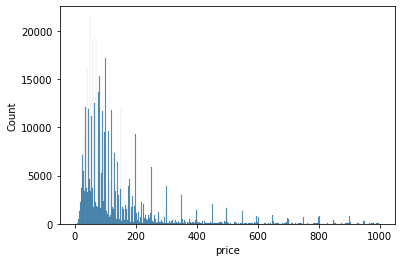

In [8]:
sns.histplot(data=df2, x="price")

Ta có thể thấy dữ liệu chủ yếu bị skew về bên phải vì một lượng lớn ảnh hưởng của outliers. Ví dụ có các nhà có giá cận 1000.

Đầu tiên, ta cần fill các dữ liệu thiếu bằng tứ phân vị Q3 sau đó khử các outlier. Điều này có thể giúp cột price skew bình thường trở lại.

In [9]:
fill_price = df2['price'].quantile(0.75)
#fill_price = df2['price'].median()
df2['price'] = df2['price'].fillna(fill_price)

In [10]:
def outlier_detection(df,x):
    Q1 = x.quantile(q=0.25)
    Q3 = x.quantile(q=0.75)
    IQR = 1.5 * abs(Q1-Q3)

    Q1_boundary = Q1 - IQR
    Q3_boundary = Q3 + IQR
    del_idx = list(df.price[(df.price < Q1_boundary) | (df.price > Q3_boundary)].index)
    return del_idx

# Delete those whose price is 0
df2 = df2[df2.price != 0]
# Remove outliers
del_idx = outlier_detection(df2,df2.price)
df2 = df2.drop(del_idx)

<AxesSubplot:xlabel='price', ylabel='Count'>

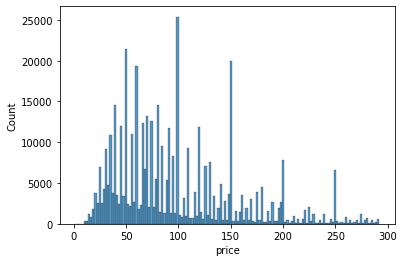

In [11]:
sns.histplot(data=df2, x="price")

#### Xử lý missing values

Khi xử lý tập dữ liệu, chúng em để ý thấy các tập hợp:
- **(host_response_rate, host_response_time)**
- **(review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month)**

In [12]:
df2['host_response_rate'] = df2['host_response_rate'].fillna(0)
df2[['host_response_time','amenities']] = df2[['host_response_time','amenities']].fillna("Not Avaialble")

In [13]:
cols = ['review_scores_cleanliness','review_scores_value','review_scores_accuracy','reviews_per_month']
df2[cols][df2['reviews_per_month'].isnull()]

,review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month
12,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,NaN
...,...,...,...,...
494928,NaN,NaN,NaN,NaN
494933,NaN,NaN,NaN,NaN
494934,NaN,NaN,NaN,NaN
494946,NaN,NaN,NaN,NaN


In [14]:
df2[cols].std()

review_scores_cleanliness    1.039317
review_scores_value          0.903184
review_scores_accuracy       0.852110
reviews_per_month            1.769312
dtype: float64

Những cột này đều có điểm chung là không có các thông số review nên không hợp lý khi ta xử lý các Nan values này một cách quá tùy tiện như thay thế bằng mod, median, mean,... Vì vậy, ta có thể xem như các ngôi nhà ở đây chưa được review trong khi thu nhập dữ liệu và điền các missing value = 0. Trong khi những cột còn lại độ lệch chuẩn không cao, khoảng 1.

In [15]:
mask = df2['reviews_per_month'].isna()
df2.loc[mask,cols] = 0

Có ba trường hợp missing đối với những cột có **reviews_per_month**:
- Cả 3 cột đều bị Nan
- Hai cột bất kì bị Nan
- Một cột bất kì bị Nan

Trường hợp 1 và 2 ta nên xóa các dòng đấy bởi vì không đủ dữ kiện để điền missing. Đối với trường hợp 3, ta có thể tính điểm trung bình của 2 cột còn lại.

In [16]:
df2[cols][df2['review_scores_cleanliness'].isnull() & df2['review_scores_value'].isnull() & df2['review_scores_accuracy'].isnull()]

,review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month
381,NaN,NaN,NaN,0.94
455,NaN,NaN,NaN,0.10
502,NaN,NaN,NaN,0.15
512,NaN,NaN,NaN,0.28
550,NaN,NaN,NaN,0.71
...,...,...,...,...
494172,NaN,NaN,NaN,0.14
494181,NaN,NaN,NaN,0.04
494182,NaN,NaN,NaN,0.03
494525,NaN,NaN,NaN,0.10


In [17]:
df2 = df2.dropna(subset=['review_scores_accuracy','review_scores_value'],how='all')
df2 = df2.dropna(subset=['review_scores_cleanliness','review_scores_value'],how='all')
df2 = df2.dropna(subset=['review_scores_accuracy','review_scores_cleanliness'],how='all')
df2 = df2.reset_index(drop=True)

In [18]:
nan_idx = list(df2[cols][df2['review_scores_accuracy'].isnull()].index)
df2[cols].iloc[nan_idx]

,review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month
3012,2.0,2.0,NaN,0.48
3385,10.0,8.0,NaN,1.00
8284,8.0,6.0,NaN,0.03
16523,8.0,8.0,NaN,0.26
29596,10.0,10.0,NaN,0.12
...,...,...,...,...
406711,8.0,10.0,NaN,0.25
415476,6.0,6.0,NaN,0.11
420651,10.0,10.0,NaN,0.03
427764,4.0,6.0,NaN,0.26


In [19]:
df2['review_scores_accuracy'] = df2['review_scores_accuracy'].fillna((df2['review_scores_value'] + df2['review_scores_cleanliness']) / 2)
df2['review_scores_value'] = df2['review_scores_value'].fillna((df2['review_scores_accuracy'] + df2['review_scores_cleanliness']) / 2)
df2['review_scores_cleanliness'] = df2['review_scores_cleanliness'].fillna((df2['review_scores_value'] + df2['review_scores_accuracy']) / 2)

In [20]:
df2[cols].iloc[nan_idx]

,review_scores_cleanliness,review_scores_value,review_scores_accuracy,reviews_per_month
3012,2.0,2.0,2.0,0.48
3385,10.0,8.0,9.0,1.00
8284,8.0,6.0,7.0,0.03
16523,8.0,8.0,8.0,0.26
29596,10.0,10.0,10.0,0.12
...,...,...,...,...
406711,8.0,10.0,9.0,0.25
415476,6.0,6.0,6.0,0.11
420651,10.0,10.0,10.0,0.03
427764,4.0,6.0,5.0,0.26


Đối với cột **calculated_host_listings_count**, bởi vì đây là cột thể hiện số lượng nhà của một host, ta chỉ cần groupby chúng bằng host_id rồi đếm số lần xuất hiện của chúng để tìm ra kết quả thực.

In [21]:
df2['calculated_host_listings_count'] = df2.groupby('host_id')['host_id'].transform('count')

In [22]:
nan_list = df2.isna().sum().to_numpy()
nan_idx = []
for i in range(len(nan_list)):
  if nan_list[i] > 0:
    tmp = []
    tmp.append(df2.keys()[i])
    tmp.append(df2[df2.keys()[i]].dtypes)
    tmp.append(nan_list[i])
    tmp.append(round(nan_list[i]/df2.shape[0] *100,2))
    nan_idx.append(tmp)
df3 = pd.DataFrame(nan_idx, columns = ["col_name","type","nan_amount","%"])
df3

,col_name,type,nan_amount,%
0,name,object,296,0.07
1,host_name,object,447,0.10
2,city,object,273,0.06
3,country,object,2,0.00


Sau khi xử lý missing value, ta chỉ còn một số cột và những cột này không cần xử lý bởi vì khi đưa vào mô hình ta sẽ drop những cột này.

## Exploratory Data Analysis

Câu hỏi:


## Quí

## Hiệu

In [23]:
df2[['host_id','host_name','calculated_host_listings_count']].groupby(['host_id','host_name']).mean()\
.sort_values('calculated_host_listings_count',ascending=False).head(5)

calculated_host_listings_count
host_id  host_name                                          
3625030  Angela                                        707.0
33889201 Tom                                           422.0
12243051 Sonder                                        208.0
         Flatbook                                      208.0
43337979 Top Villas Mallorca                           191.0

## Model

Trước khi thực hiện tạo mô hình học máy, ta cần xử lý các công đoạn quan trọng như khử outlier, loại bỏ các cột không cần thiết, encode các dữ liệu dạng chữ,...

In [24]:
# Drop unnecessary columns
df2 = df2.drop(['id','latitude','longitude','name','host_id','host_name','host_url'],axis=1)

### Encoding Variables

Ta sẽ giữ nguyên 100 thành phố tập trung đông các nhà được đăng ký và cho các thành phố còn lại thành **Others**

In [25]:
top_city = 100
need_city = df2['city'].value_counts().head(top_city).index.tolist()

df2.loc[~df2['city'].isin(need_city), 'city'] = 'Other'

In [26]:
len(df2[df2['city'].isin(need_city)]) / len(df2) * 100

87.46698410667446

Ta chọn top 100 thành phố đông nhất bởi vì chỉ với 100 thành phố trên đã chiếm ~87% dữ liệu

Spearman's rank correlation, một version khác của Pearson correlation, là một kiểm tra phi tham số về mức độ tương quan, sức mạnh, hướng liên kết giữa hai biến được đo lường trên một thước đo nhất định. Tương quan Spearman có thể được sử dụng khi các giả định của tương quan Pearson bị vi phạm rõ rệt. Tuy nhiên, tương quan của Spearman xác định cường độ và hướng của mối quan hệ đơn điệu (motonic relationship) giữa hai biến chứ không phải cường độ và hướng của mối quan hệ tuyến tính (linear relationship).

Đầu tiên, ta cần lọc ra những cột nào là numeric, cột nào là category.

In [27]:
numeric_cols = [f for f in df2.columns if df2.dtypes[f] != 'object']
categorical_cols = [f for f in df2.columns if df2.dtypes[f] == 'object']

del_cols = ['city','country','neighbourhood_cleansed','amenities','features']
categorical_cols = [x for x in categorical_cols if (x not in del_cols)]

Sau đó thực hiện spearman's rank correlation encoding với thước đo là độ trung bình của cột target (price)

In [28]:
# Encode categorical columns with spearman's rank correlation
df4 = df2.copy()
def encode(df, feature):
    ordering = pd.DataFrame()
    ordering['val'] = df[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = df[[feature, 'price']].groupby(feature).mean()['price']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    print(feature,ordering[['spmean','ordering']])
    ordering = ordering['ordering'].to_dict()

    for cat, o in ordering.items():
        df.loc[df[feature] == cat, feature+'_E'] = o
    
encoded_cols = []
for q in categorical_cols:
    encode(df4,q)
    encoded_cols.append(q+'_E')

df4['amenities'] = df4['amenities'].transform(lambda x: x.lower().split(","))

host_response_time                         spmean  ordering
val                                     
a few days or more   89.235103         1
Not Avaialble        93.993131         2
within an hour       97.449265         3
within a day         98.230145         4
within a few hours  100.978854         5
property_type                             spmean  ordering
val                                         
Pension (Korea)          37.000000         1
Casa particular          45.333333         2
Hostel                   46.873057         3
Parking Space            50.000000         4
Ryokan (Japan)           62.000000         5
Hut                      64.461538         6
Plane                    65.000000         7
Dorm                     67.002846         8
Tent                     73.326316         9
Island                   73.800000        10
Bed & Breakfast          78.592208        11
Heritage hotel (India)   79.000000        12
Tipi                     80.466667        13
In-la

Đối với các cột như city, country và amenities là kiểu dữ liệu dạng phân loại, chúng cần được thực hiện encoding với get_dummies. Hàm get_dummies được sử dụng để chuyển đổi các biến phân loại thành biến giả hoặc biến chỉ báo. Biến giả hoặc biến chỉ báo có thể có giá trị 0 hoặc 1.

In [29]:
dummy_city = pd.get_dummies(df4.city, prefix="city")
dummy_country = pd.get_dummies(df4.country, prefix="country")
mlb = MultiLabelBinarizer()
dummy_amenities = pd.DataFrame(mlb.fit_transform(df4['amenities']),columns=mlb.classes_, index=df4.index)

In [30]:
dummy_city

,city_Alcúdia,city_Amsterdam,city_Antwerpen,city_Athens,city_Athina,city_Austin,city_Barcelona,city_Berlin,city_Beverly Hills,city_Bondi,...,city_Toronto,city_Vancouver,city_Venezia,city_Venice,city_Vienna,city_Ville de Québec,city_Washington,city_West Hollywood,city_Wien,city_Αθήνα
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437663,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
437664,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
437665,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
437666,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
dummy_amenities

,24-hour check-in,accessible-height bed,accessible-height toilet,air conditioning,baby bath,baby monitor,babysitter recommendations,bathtub,bbq grill,beach essentials,...,washer,washer / dryer,waterfront,wheelchair accessible,wide clearance to bed,wide clearance to shower and toilet,wide doorway,wide hallway clearance,window guards,wireless internet
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437663,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
437664,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
437665,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
437666,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


Cuối cùng, ta gộp các cột cần thiết để huấn luyện mô hình lại để sang công đoạn tiếp theo.

In [32]:
df5 = pd.concat([df4[encoded_cols + numeric_cols], dummy_city, dummy_country,dummy_amenities], axis=1)
df5 = df5.drop(['translation missing: en.hosting_amenity_49','translation missing: en.hosting_amenity_50'],axis=1)

In [33]:
df5

,host_response_time_E,property_type_E,room_type_E,bed_type_E,cancellation_policy_E,host_response_rate,accommodates,bathrooms,bedrooms,beds,...,washer,washer / dryer,waterfront,wheelchair accessible,wide clearance to bed,wide clearance to shower and toilet,wide doorway,wide hallway clearance,window guards,wireless internet
0,5.0,20.0,3.0,5.0,8.0,100.0,4.0,1.0,2.0,2.0,...,1,0,0,0,0,0,0,0,0,1
1,2.0,20.0,3.0,5.0,5.0,0.0,4.0,1.0,2.0,2.0,...,1,0,0,0,0,0,0,0,0,1
2,4.0,20.0,3.0,5.0,5.0,100.0,4.0,1.0,2.0,4.0,...,1,0,0,0,0,0,0,0,0,1
3,4.0,20.0,3.0,5.0,6.0,100.0,2.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,4.0,20.0,3.0,5.0,8.0,100.0,2.0,1.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437663,5.0,20.0,3.0,5.0,8.0,100.0,6.0,1.0,3.0,6.0,...,1,0,0,0,0,0,0,0,0,1
437664,3.0,20.0,2.0,5.0,6.0,100.0,2.0,1.5,1.0,2.0,...,1,0,0,0,0,0,0,0,0,1
437665,4.0,20.0,2.0,5.0,5.0,100.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
437666,3.0,20.0,2.0,5.0,5.0,100.0,1.0,1.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,1


Bảng dữ liệu "nở" ra khá nhiều khi giờ đây, ta có tận 255 feature khác nhau để miêu tả chi tiết từng căn nhà được đăng ký.

In [34]:
# Stop running
stop !!

### Prepare data

Đầu tiên, ta cần đảm bảo dữ liệu sẵn sàng như tách X,y và tiến hành normalize/scale chúng bằng hàm StandardScaler. Ý tưởng đằng sau StandardScaler là nó sẽ biến đổi dữ liệu của bạn sao cho phân phối của nó sẽ có giá trị trung bình là 0 và độ lệch chuẩn là 1. Sau đó phân chia tập train và validation theo tỷ lệ 8:2

In [35]:
X = df5.loc[:, df5.columns != 'price']
y = df5[['price']]

X_scaled = X
y_scaled = y

TargetVarScaler=StandardScaler()
TargetVarScalerFit=TargetVarScaler.fit(y_scaled)
y_scaled=TargetVarScalerFit.transform(y)

X_array = np.array(df5.values).astype("float32")
y_array = np.array(y_scaled).astype("float32")

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=2032)
y_test_orig = TargetVarScalerFit.inverse_transform(y_test)

Một số metrics như MAPE và RMSE có thể sử dụng để có thể đánh giá mô hình.

- Mean Absolute Percentage Error (MAPE) : Sai số phần trăm tuyệt đối trung bình, còn được gọi là độ lệch phần trăm tuyệt đối trung bình, là thước đo độ chính xác dự đoán của một phương pháp dự báo trong thống kê. Bởi vì giá trị được tính là phần trăm nên khi áp dụng thực tế, ta có thể lấy 100 - MAPE để ra được độ chính xác tuyệt đối của mô hình.

- Root Mean Square Error (RMSE): là căn bậc hai của mức trung bình của các sai số bình phương. RMSE là độ lệch chuẩn của các phần dư (sai số dự đoán). Phần dư là thước đo khoảng cách từ các điểm dữ liệu đường hồi quy; RMSE là thước đo mức độ dàn trải của những phần dư này, nói cách khác, nó cho bạn biết mức độ tập trung của dữ liệu xung quanh đường phù hợp nhất. RMSE càng nhỏ thì mô hình càng tốt.

- Learning Curve: Đường cong học tập vẽ biểu đồ giá trị tối ưu của hàm mất mát của mô hình cho một tập huấn luyện dựa trên hàm mất mát này được đánh giá trên tập dữ liệu xác nhận với các tham số giống như được tạo ra của hàm tối ưu.

In [36]:
def Accuracy_Score(orig, pred):
    MAPE = np.mean(100 * (np.abs(orig - pred) / orig))
    return(100-MAPE)

In [37]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
def cv_rmse(model1, X,y):
    rmse = np.sqrt(-cross_val_score(model1, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [38]:
def plot_curves(X_train,X_test,y_train,y_test,clf,title):
  plot_learning_curves(X_train=X_train,
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      clf=clf,
                      scoring='mean_squared_error',
                      print_model=False)
  
  plt.title(title)
  plt.show()

Ngoài ra, ta cũng cần chuẩn bị một hàm PCA cho việc giảm chiều dữ liệu

In [39]:
from sklearn.decomposition import PCA
def PCA_process(X):
  pca_impl = PCA(n_components = 2)
  X_pca = pca_impl.fit_transform(X)
  return X_pca

### K-nearest Neighbors Regression

**KNN (K-Nearest Neighbors)** là một trong những thuật toán học có giám sát đơn giản nhất được sử dụng nhiều trong khai phá dữ liệu và học máy. Ý tưởng của thuật toán này là nó không học một điều gì từ tập dữ liệu học (nên KNN được xếp vào loại **lazy learning**), mọi tính toán được thực hiện khi nó cần dự đoán nhãn của dữ liệu mới. Lớp(nhãn) của một đối tượng dữ liệu mới có thể dự đoán từ các lớp(nhãn) của k hàng xóm gần nó nhất.

Giả sử ta có D là tập các dữ liệu đã được phân loại thành 2 nhãn (+) và (-) và một số điểm dữ liệu mới chưa biết nhãn. Vậy làm cách nào để chúng ta có thể xác định được nhãn của A là (+) hay (-)?

KNN sẽ thực hiện một phép tính toán học để đo khoảng cách giữa dữ liệu mới với tất cả các điểm trong tập dữ liệu học để thực hiện phân lớp. Phép tính khoảng cách giữa 2 điểm có thể là **Euclidian, Manhattan, trọng số, Minkowski, …**

Khi KNN thực hiện dự đoán hồi quy với một điểm dữ liệu mới, chúng sẽ lấy **k** điểm dữ liệu có đặc trưng giống với điểm dữ liệu mới này dựa vào khoảng cách đã tính ở trên rồi trả về kết quả trung bình của chúng. Tuy nhiên KNN khá nhạy cảm và vulnerable với dữ liệu đa chiều nên ta cần thực hiện PCA trước khi áp dụng thuật toán này.

In [40]:
X_pca = PCA_process(X_array)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_array, test_size=0.2, random_state=2032)

Ta cần có ba list là rmse_val, accuracy_score và result_val để lưu trữ RMSE, Accuracy và kết quả để có thể lấy được kết quả dự đoán sau khi tìm ra k tốt nhất.

In [41]:
rmse_val = [] #to store rmse values for different k
accuracy_score = []
result_val = []
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_pca, y_train_pca)  #fit the model
    pred=model.predict(X_test_pca) #make prediction on test set
    error = sqrt(mean_squared_error(y_test_pca,pred)) #calculate rmse
    acc_score = Accuracy_Score(y_test_pca, pred) #calculate accuracy
    rmse_val.append(error) #store rmse values
    accuracy_score.append(acc_score)
    result_val.append(pred)
    #print('RMSE value for k= ' , K , 'is:', error)

In [42]:
minpos = rmse_val.index(min(rmse_val))
print("K = ",minpos)

K =  9


Với k trong khoảng [1,20], ta tìm được k = 9 là k optimal bởi vì đây là k có độ lỗi RMSE thấp nhất.

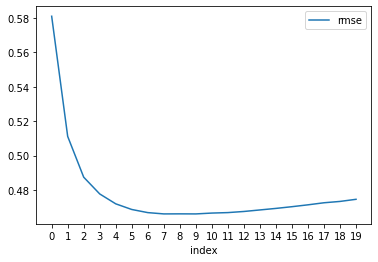

In [43]:
#elbow curve
curve = pd.DataFrame(rmse_val,columns=['rmse']) 
curve.reset_index().plot(x='index', y='rmse')
plt.xticks(range(0,20))
plt.show()

In [45]:
minpos = rmse_val.index(min(rmse_val))
print("Accuracy of the Linear model is:", accuracy_score[minpos])
print("RMSE of the Linear model is:", rmse_val[minpos])

Accuracy of the Linear model is: 93.40405893325806
RMSE of the Linear model is: 0.46605191980757826


In [46]:
# Extract result
pred_org = TargetVarScalerFit.inverse_transform(result_val[minpos])

In [47]:
# Create dataframe for representing results
combine_pred = np.append(y_test_orig , pred_org,axis=1)
df_knn_pred = pd.DataFrame(combine_pred,columns=['True result','Predicted result'])

In [48]:
df_knn_pred.head(10)

,True result,Predicted result
0,46.999996,47.400002
1,96.000000,103.500000
2,149.000000,110.000000
3,80.000000,99.500000
4,80.000000,77.599998
5,95.000000,96.400002
6,100.000000,102.400002
7,89.000000,82.500000
8,45.000000,66.900002
9,80.000000,80.500000


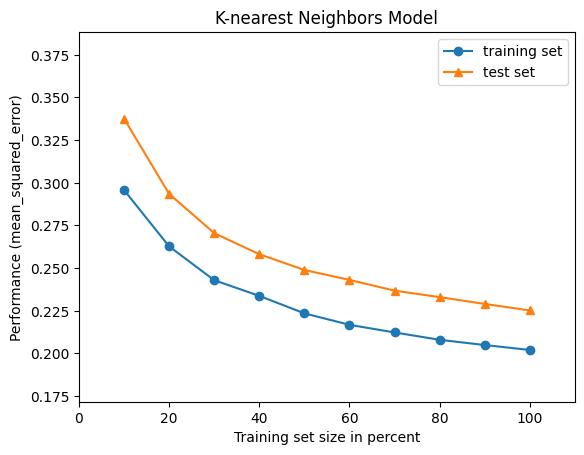

In [49]:
plot_curves(X_train_pca,X_test_pca,y_train_pca,y_test_pca,model,"K-nearest Neighbors Model")

#### Nhận xét

- Mô hình hồi quy KNN biểu hiện khá tốt với tập dữ liệu trên với độ chính xác tính theo MAPE là ~90% và độ lỗi RMSE chỉ có ~0.5.
- Ta có thể thấy Learning Curve của mô hình KNN bị một chút overfit khi mô hình trên biểu hiện tập train tốt hơn tập test. 
- Tuy nhiên, chúng vẫn có điểm chung là độ lỗi khi tập dữ liệu tăng lên đều có dấu hiệu giảm dần.

### Linear Regression

**Hồi quy tuyến tính(Linear Regression)** là một phương pháp thống kê để hồi quy dữ liệu với biến phụ thuộc có giá trị liên tục trong khi các biến độc lập có thể có một trong hai giá trị liên tục hoặc là giá trị phân loại. Nói cách khác Hồi quy tuyến tính là một phương pháp để dự đoán biến phụ thuộc (Y) dựa trên giá trị của biến độc lập (X). Nó có thể được sử dụng cho các trường hợp chúng ta muốn dự đoán một số lượng liên tục. Ví dụ, dự đoán giao thông ở một cửa hàng bán lẻ, dự đoán thời gian người dùng dừng lại một trang nào đó hoặc số trang đã truy cập vào một website nào đó v.v...

In [50]:
reg = LinearRegression().fit(X_train,y_train)
linear_predictions = reg.predict(X_test)

linear_predictions_orig = TargetVarScalerFit.inverse_transform(linear_predictions)

In [51]:
print("Accuracy of the Linear model is:", str(Accuracy_Score(y_test_orig, linear_predictions_orig)))
print("RMSE of the Linear model is:", cv_rmse(reg,X_array,y_array).mean())

Accuracy of the Linear model is: 99.92962788045406
RMSE of the Linear model is: 0.0010536097709691332


In [52]:
combine_pred = np.append(y_test_orig , linear_predictions_orig,axis=1)
df_linear_pred = pd.DataFrame(combine_pred,columns=['True result','Predicted result'])

In [53]:
df_linear_pred.head(10)

,True result,Predicted result
0,46.999996,46.975368
1,96.000000,95.935600
2,149.000000,148.962708
3,80.000000,80.028412
4,80.000000,79.960808
5,95.000000,95.083855
6,100.000000,100.014450
7,89.000000,88.982765
8,45.000000,44.968033
9,80.000000,79.944450


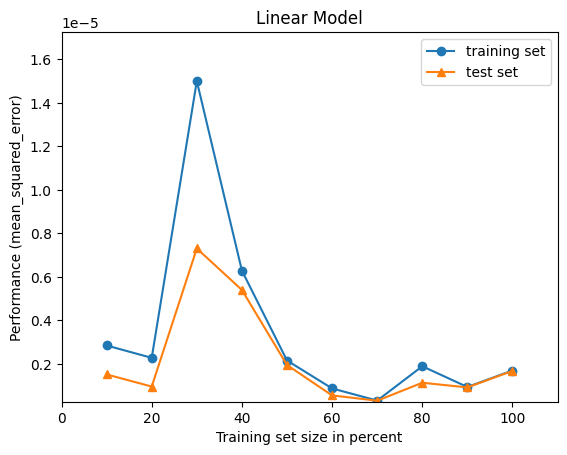

In [54]:
plot_curves(X_train,X_test,y_train,y_test,reg,"Linear Model")

#### Nhận xét
- Mô hình hồi quy Linear Regression biểu hiện rất tốt với tập dữ liệu trên với độ chính xác tính theo MAPE là ~99% và độ lỗi RMSE chỉ có ~0.0015.
- Ta có thể thấy Learning Curve của mô hình Linear Regression từ 60% size trở lên đều duy trì ở mức rất thấp mặc dù có tăng một chút ở 90-100%.
- Mặc dù sở hữu độ chính xác cao và độ lỗi thấp, mô hình không hề bị Overfitting. Bởi vì Learning Curve của tập test luôn luôn có độ lỗi thấp hơn tức là biểu hiện tốt hơn tập train.

### ANN Deep Learning

Artificial Neural Network (ANN) gồm 3 thành phần chính: Input layer và output layer chỉ gồm 1 layer , hidden layer có thể có 1 hay nhiều layer tùy vào bài toán cụ thể. ANN hoạt động theo hướng mô tả lại cách hoạt động của hệ thần kinh với các neuron được kết nối với nhau. Trong ANN, trừ input layer thì tất cả các node thuộc các layer khác đều full-connected với các node thuộc layer trước nó. Mỗi node thuộc hidden layer nhận vào ma trận đầu vào từ layer trước và kết hợp với trọng số để ra được kết quả. ANN còn được gọi là Feed-Forward Neural network.

Lý do ta chọn ANN là bởi vì ANN rất chắc chắn trong việc học những function phi tuyến tính(non-linear). Hàm activation của ANN cũng đóng vai trò quan trọng khi chúng có các weights cho từng các input phi tuyến tính vào trong mạng và trả về một kết quả duy nhất. Nhờ vào đó mà các network có thể học bất kì mối quan hệ phức tạp nào giữa input và output.

In [61]:
ANN = Sequential()                
ANN.add(Dense(units=10, input_dim=X_train.shape[1], 
                kernel_initializer='normal', activation='relu'))
ANN.add(Dense(1, kernel_initializer='normal'))
ANN.compile(loss='mean_squared_error', optimizer={'batch_size': 30, 'epochs': 20, 'optimizer_trial': 'rmsprop'}['optimizer_trial'])
ANN.fit(X_train, y_train,batch_size = int({'batch_size': 30, 'epochs': 20, 'optimizer_trial': 'rmsprop'}['batch_size']),
        epochs = int({'batch_size': 30, 'epochs': 20, 'optimizer_trial': 'rmsprop'}['epochs']), verbose=0)

ANN_predictions = ANN.predict(X_test)

ANN_predictions_org = TargetVarScalerFit.inverse_transform(ANN_predictions)

In [62]:
print("Accuracy for the ANN model is:", str(Accuracy_Score(y_test_orig, ANN_predictions_org)))

Accuracy for the ANN model is: 95.0540542602539


In [63]:
combine_pred = np.append(y_test_orig , ANN_predictions_org,axis=1)
df_ANN_pred = pd.DataFrame(combine_pred,columns=['True result','Predicted result'])

In [64]:
df_ANN_pred.head(10)

,True result,Predicted result
0,46.999996,45.466518
1,96.000000,93.581223
2,149.000000,143.816635
3,80.000000,78.606468
4,80.000000,77.526276
5,95.000000,90.223640
6,100.000000,98.476418
7,89.000000,86.981071
8,45.000000,45.066883
9,80.000000,78.092896


In [65]:
ANN1 = Sequential()                
ANN1.add(Dense(units=10, input_dim=X_train.shape[1], 
                kernel_initializer='normal', activation='relu'))
ANN1.add(Dense(1, kernel_initializer='normal'))
ANN1.compile(loss='mean_squared_error', optimizer={'batch_size': 30, 'epochs': 20, 'optimizer_trial': 'rmsprop'}['optimizer_trial'])

10942/10942 [==============================] - 8s 704us/step - loss: 33360334.0000


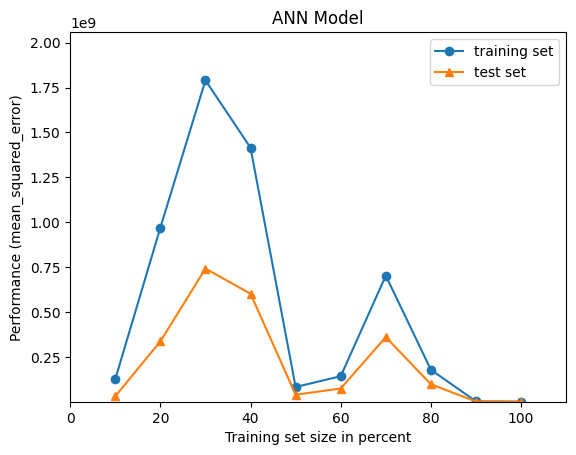

In [66]:
plot_curves(X_train,X_test,y_train,y_test,ANN1,"ANN Model")

#### Nhận xét:
- Mô hình học sâu ANN biểu hiện rất tốt với tập dữ liệu trên với độ chính xác tính theo MAPE là ~95%.
- Giống với Linear Regression, ANN có độ chính xác cao và không hề bị Overfitting. 
- Learning Curve của ANN có biểu hiện khá giống với Linear Regression khi độ lỗi MSE của tập test luôn thấp hơn tập train.
- Khá thú vị rằng từ 90% trở đi, độ lỗi của chúng gần như cận 0 chứng tỏ mô hình Deep Learning của ta khá tốt.

## Reference
- https://bnbfacts.com/how-airbnb-category-ratings-affect-overall-rating/
- https://kabir-isak.medium.com/airbnb-seattle-data-analysis-2e01f2559614
- https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
- http://rasbt.github.io/mlxtend/user_guide/plotting/plot_learning_curves/
- https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/
- https://viblo.asia/p/linear-regression-hoi-quy-tuyen-tinh-trong-machine-learning-4P856akRlY3
- https://viblo.asia/p/tong-quan-ve-artificial-neural-network-1VgZvwYrlAw
- https://en.wikipedia.org/wiki/Artificial_neural_network